# Plume identification in SO2 data

In [1]:
# Required imports

import pandas as pd
import datetime
import matplotlib.pyplot as plt
import matplotlib as mpl
import datetime
import numpy as np
mpl.rcParams['figure.figsize'] = (14.0, 8.0)

First, let's load the data and do a bit of housekeeping...

In [40]:
columns = ["conc", "a", "b"]

# Load data
data = pd.read_csv('C258_FGGA_FAAM.txt', names=columns, parse_dates=True, header=1, date_parser=lambda x:datetime.datetime.strptime(x, '%d/%m/%Y %H:%M:%S.%f'))

And plot the SO2 concentration to make sure everything look sensible...

Text(0, 0.5, 'SO2 conc.')

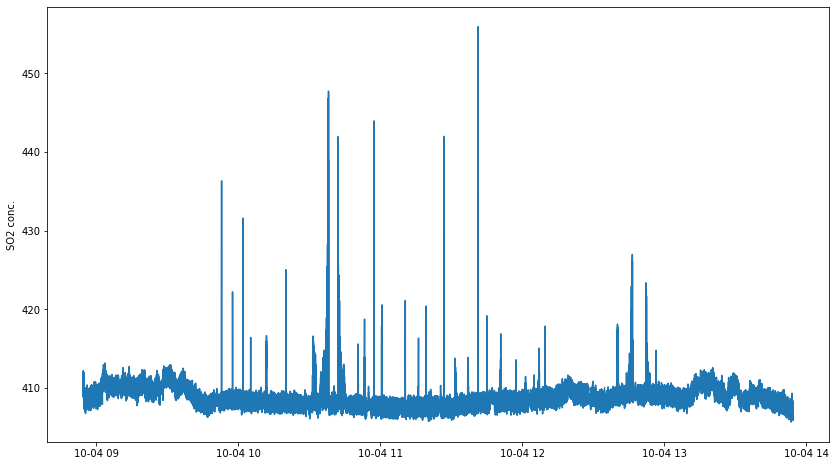

In [41]:
plt.plot(data.conc)
plt.ylabel('SO2 conc.')

We want to identify an area to use as a background. To do this we're going to

* Create a smoothed rolling average of standard deviation
* Ignore any data where this metric is above a specified value
* Use the longest continuous interval to derive background statistics

The plot below highlights in red the areas which can be considered as background

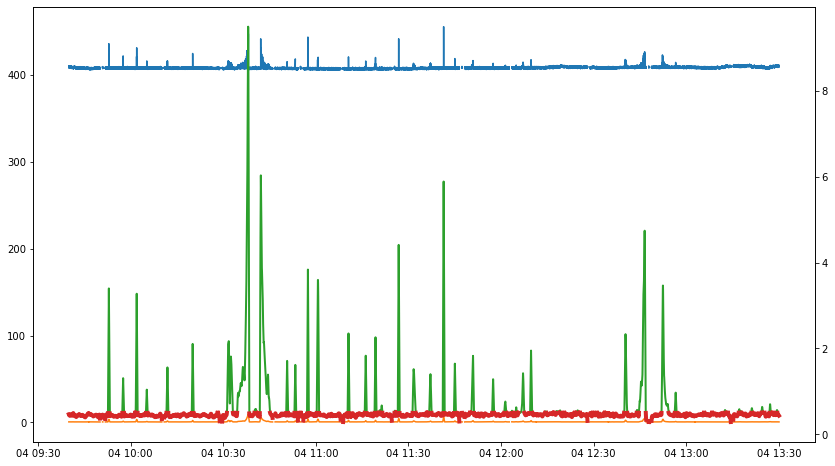

In [42]:
ROLLING_PERIOD = 180

start_time = datetime.datetime(2021,10,4,9,40,0)
end_time = datetime.datetime(2021,10,4,13,30,0)
time_filter = (data.index >= start_time) & (data.index <= end_time)
plt.plot(data.conc.loc[time_filter])

nans = data.conc.isna()
std = data.conc.fillna(method='ffill').rolling(ROLLING_PERIOD, center=True).std().rolling(ROLLING_PERIOD, center=True).mean().loc[time_filter]
std.loc[nans] = np.nan
plt.plot(std)
std_low = std.copy()
std_low.loc[std_low > .5] = np.nan
plt.gca().twinx().plot(std, color='tab:green', linewidth=2)
plt.plot(std_low, 'tab:red', linewidth=4)

And we can use these to derive basic background stats, using the longest inteval, shown in magenta. The
mean and standard deviation for this period are also given

84
Background mean: 408.03041104162173
Background std: 0.4499034961603972


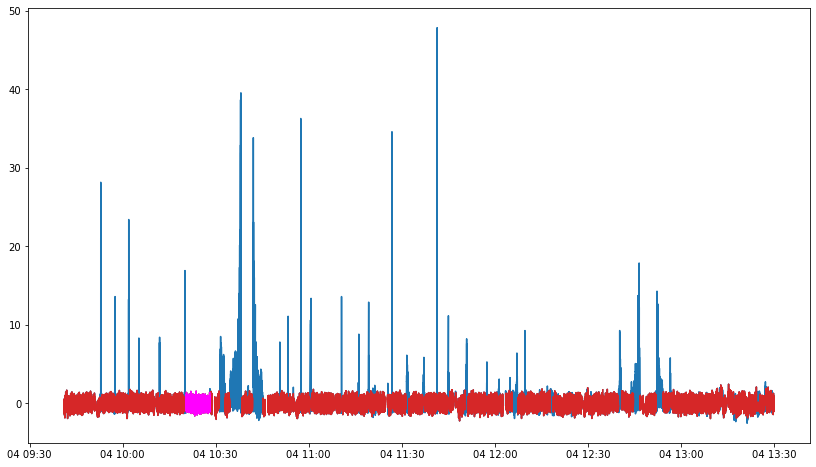

In [78]:
s = pd.DataFrame(std_low.dropna())
s['i'] = s.index.values.astype(int) / 1e9
groups = s.groupby((s.i.diff().abs() > 2).cumsum())
longest_group = sorted(groups, key=lambda x: len(x[1]))[-1]
print(len(groups))

group_times = [i[1].index for i in groups]
idx = group_times[0]
for gt in groups.apply(lambda x: x.index):
    idx = idx.union(gt)
    
bg = data.conc.loc[idx].reindex(data.index).interpolate().rolling(660).mean()
# plt.plot(bg.rolling(180).mean(), 'k', linewidth=3)

plt.plot(data.conc[time_filter] - bg.loc[time_filter])
for group in groups:
    plt.plot(data.conc[group[1].index] - bg.loc[group[1].index], color='tab:red')
plt.plot(data.conc.loc[longest_group[1].index] - bg.loc[longest_group[1].index], color='magenta')
    
bg_mean = data.conc.loc[longest_group[1].index].mean()
bg_std = data.conc.loc[longest_group[1].index].std()

print(f'Background mean: {bg_mean}')
print(f'Background std: {bg_std}')


Our first iteration of plume identification is wherever the concentration exceeds a specified number of standard deviations from the background mean.

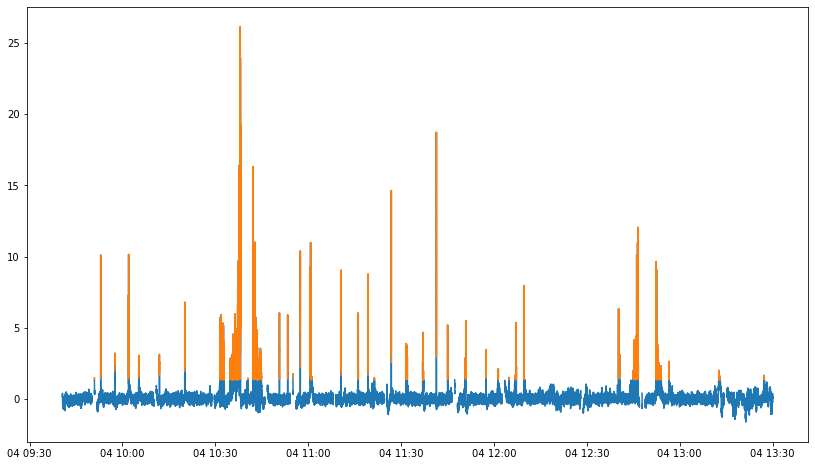

In [67]:
N_STDS = 3

conc = (data.conc.loc[time_filter]-bg[time_filter]).rolling(10).mean()
plt.plot(conc)
conc_plume = conc.copy()
conc_plume[conc_plume < N_STDS*bg_std] = np.nan
plt.plot(conc_plume)
# plt.plot([conc.index[0], conc.index[-1]], [bg_mean + N_STDS*bg_std]*2, '--')
# plt.gca().set_ylim([-1 ,10])

We then isolate each contiguous bit of plume data

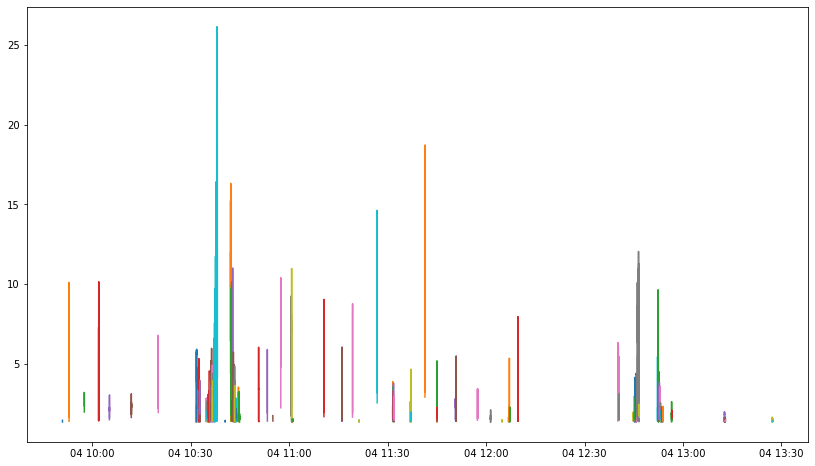

In [68]:
conc_plume = pd.DataFrame(conc_plume)
conc_plume['i'] = conc_plume.index.values.astype(int) / 1e9
groups = [
    i[1] for i in conc_plume.groupby((conc_plume.dropna().i.diff().abs() > 1).cumsum())
]

for grp in groups:
    plt.plot(grp.conc)

We then extend each of these plumes until they hit a specified number of standard deviations from the background

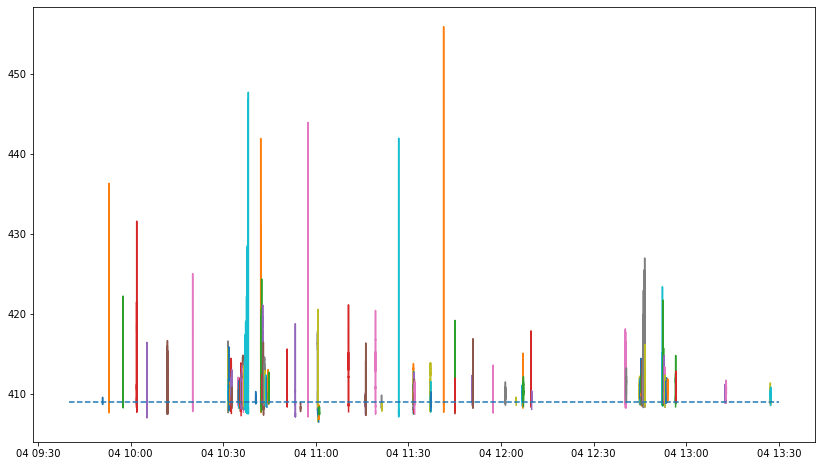

In [69]:
CUTOFF_N_STD = 2

plumes = []
for grp in groups:
    start = data.conc.loc[data.index < grp.index[0]]
    start[start > (bg_mean + CUTOFF_N_STD*bg_std)] = np.nan
    start = start.dropna().tail(1)
    plumes.append(data.conc.loc[(data.index>=start.index[0]) & (data.index<=grp.index[-1])])
    
for plume in plumes:
    plt.plot(plume)
plt.plot([conc.index[0], conc.index[-1]], [bg_mean + 2*bg_std]*2, '--')

And then add a buffer of a specified number of seconds to each plume

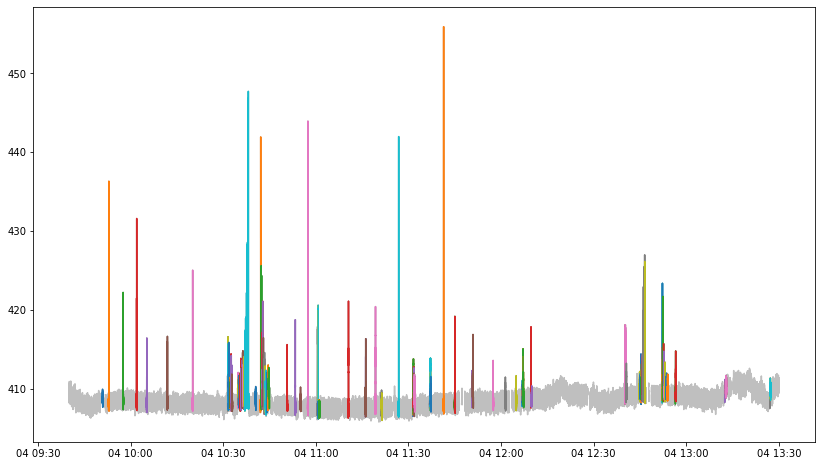

In [70]:
BUFFER_TIME = datetime.timedelta(seconds=5)

expanded_plumes = []
for plume in plumes:
    expanded_plumes.append(
        data.conc.loc[(data.index >= plume.index[0] - BUFFER_TIME) & (data.index <= plume.index[-1] + BUFFER_TIME)]
    )

plt.plot(data.conc.loc[time_filter], color='gray', alpha=.5)
for plume in expanded_plumes:
    plt.plot(plume)
    

And finally we merge any plumes which have overlapping start and end points

In [71]:
index = expanded_plumes[0].index
for plume in expanded_plumes[1:]:
    index = index.union(plume.index)

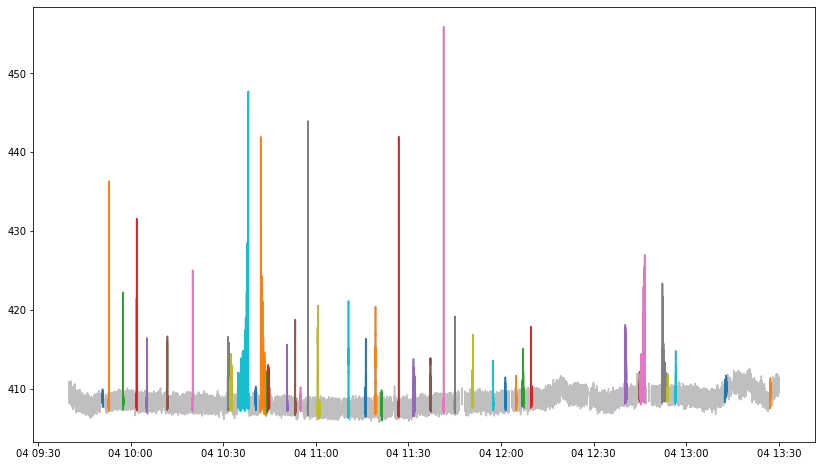

In [72]:
plumes = data.conc.copy() * np.nan
plumes.loc[index] = data.conc[index]
plumes = pd.DataFrame(plumes)
plumes['i'] = plumes.index.astype(int) / 1e9
groups = plumes.groupby((plumes.dropna().i.diff().abs() > 1).cumsum())

plt.plot(data.conc.loc[time_filter], color='gray', alpha=.5)
for group in groups:
    plt.plot(group[1].conc)

We can sum each plume to pretend we're integrating

In [37]:
for grp in groups:
    i, df = grp
    print(f'plume {int(i)+1}: {df.index[0]} - {df.index[-1]} -> {df.conc.sum()}')

plume 1: 2021-10-04 09:40:00 - 2021-10-04 09:41:14 -> 26.879015949218566
plume 2: 2021-10-04 09:42:05 - 2021-10-04 09:50:06 -> 171.37628130811072
plume 3: 2021-10-04 09:50:57 - 2021-10-04 09:51:56 -> 26.91620558392867
plume 4: 2021-10-04 09:54:23 - 2021-10-04 09:58:16 -> 101.16617712745273
plume 5: 2021-10-04 10:04:12 - 2021-10-04 10:10:05 -> 127.25383727277816
plume 6: 2021-10-04 10:10:56 - 2021-10-04 10:26:34 -> 373.4241159207496
plume 7: 2021-10-04 10:27:25 - 2021-10-04 10:28:52 -> 30.094998974615752
plume 8: 2021-10-04 10:47:43 - 2021-10-04 10:48:27 -> 21.26910603144985
plume 9: 2021-10-04 10:52:55 - 2021-10-04 10:54:12 -> 29.733413058365873
plume 10: 2021-10-04 11:03:51 - 2021-10-04 11:08:00 -> 97.9872440430631
plume 11: 2021-10-04 11:08:51 - 2021-10-04 11:24:36 -> 374.8780674062682
plume 12: 2021-10-04 11:39:51 - 2021-10-04 11:46:28 -> 151.94922786528338
plume 13: 2021-10-04 11:47:19 - 2021-10-04 12:02:32 -> 350.52576046144515
plume 14: 2021-10-04 12:03:23 - 2021-10-04 12:17:42 -

In [38]:
!mv /home/daspr/Downloads/C258_FGGA_FAAM.txt .